### Criteria 1: Exclude data with no motion. (i.e. Cc100)
for each_slice in Mu:
    # initialize slice count
    good_slice_count = 0
    bad_slice_count = 0 

    for each non-nan pixel in each_slice:
        COUNT pixel > 6,000 AS mu_over
        COUNT pixel < 6,000 AS mu_under
        total = mu_over + mu_under
        p = mu_over / total
        if p >= 0.8:
            bad_slice_count += 1
        else:
            good_slice_count += 1
    if bad_slice_count >= 1: # we dont want any slices have no motion 
        CLASSIFY bad data
    else:
        CLASSIFY good data

In [14]:
# import
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import scipy.ndimage
from scipy.stats import entropy

In [3]:
# load data:
mu_path = "/home/smooi/Desktop/toast/data/Mu_Exp/Cc111_Mu.mat"

stiff_data = scipy.io.loadmat(mu_path)
mu = stiff_data["Mu"]
# print max, min of Mu
# select = mu[:, :, 10]
# max_stiff = np.nanmax(select)
# min_stiff = np.nanmin(select)
# print(mu.shape[2])

# rule: 
# if 80% of the pixels have stiffness greater than 6,000 kPa --> Bad data
def look_at_slice(matrix):
    good_slice_count = 0
    bad_slice_count = 0 
    bad_slices = []
    good_slices = []
    
    for slice_x in range(matrix.shape[2]):
        selected_slice = matrix[:, :, slice_x]
        
        # Ignore NaN values: we dont want them to mess up with the mu_over and mu_under 
        valid_pixels = selected_slice[~np.isnan(selected_slice)] #  Selects only the non-NaN values.

        if valid_pixels.size == 0: # prevent division by zero error 
            print(f"Slice {slice_x}: No valid pixels (all NaN). Skipping!")
            continue 
        
        mu_over = np.sum(valid_pixels >= 6000)
        mu_under = np.sum(valid_pixels < 6000)
        total = mu_over + mu_under

        prop = mu_over / total 
        
        if prop < 0.8:  # Corrected condition
            good_slice_count += 1
            good_slices.append(slice_x)
        else:
            bad_slice_count += 1
            bad_slices.append(slice_x)
    
    print(f"There are {bad_slice_count} bad data.")
    # print(bad_slices)
    print(f"There are {good_slice_count} good data.")
    # print(good_slices)
    
    subj_name = (mu_path.split("/"))[-1].split(".")[0]
    # print(subj_name)
    
    if bad_slice_count > 0:
        print(f"Subject {subj_name} is a bad data!")
    else:
        print(f"Subject {subj_name} is a ok data!")
look_at_slice(mu)

Slice 47: No valid pixels (all NaN). Skipping!
There are 0 bad data.
There are 47 good data.
Subject Cc111_Mu is a ok data!


### Criteria 2: Exclude data with little to No motion
After excluding data with no motion at all, we want to exclude data with little to no motion. 
Note: need some good and bad data to determine threshold 

/tmp/ipykernel_53511/2224879866.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


([np.float64(2686.5697010885697),
  np.float64(2660.972810866027),
  np.float64(2340.036451130438),
  np.float64(3039.014202828214),
  np.float64(1992.010828730708),
  np.float64(1843.0884441621101),
  np.float64(2007.0656273003708),
  np.float64(2132.093348649072),
  np.float64(3964.030839283789),
  np.float64(4669.18153854146),
  np.float64(4483.994310053998),
  np.float64(4225.712666473028),
  np.float64(3538.9004840712205),
  np.float64(3412.4853519797593),
  np.float64(3739.0486600832683),
  np.float64(3783.437624320939),
  np.float64(4235.360549297895),
  np.float64(4750.845362694603),
  np.float64(4280.773111997922),
  np.float64(3972.372061841979),
  np.float64(3011.080123115014),
  np.float64(2533.4156936549934),
  np.float64(2206.992880149557),
  np.float64(2291.232777799812),
  np.float64(2482.894180745172),
  np.float64(2331.2614846692104),
  np.float64(2064.007100728063),
  np.float64(2128.7676659325475),
  np.float64(2120.639362286093),
  np.float64(2302.306737068016),
  

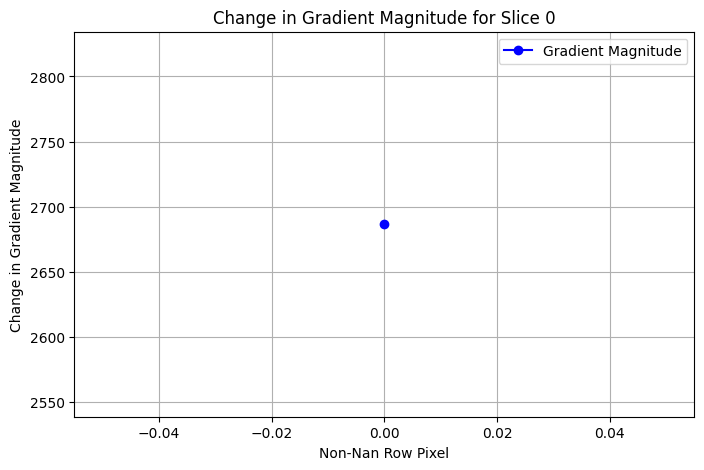

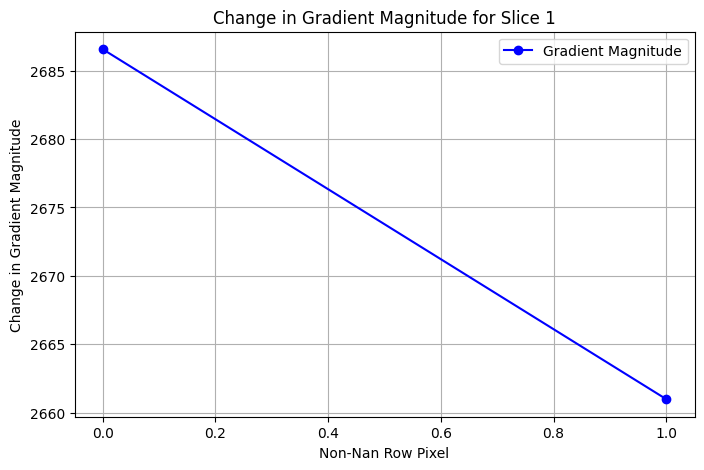

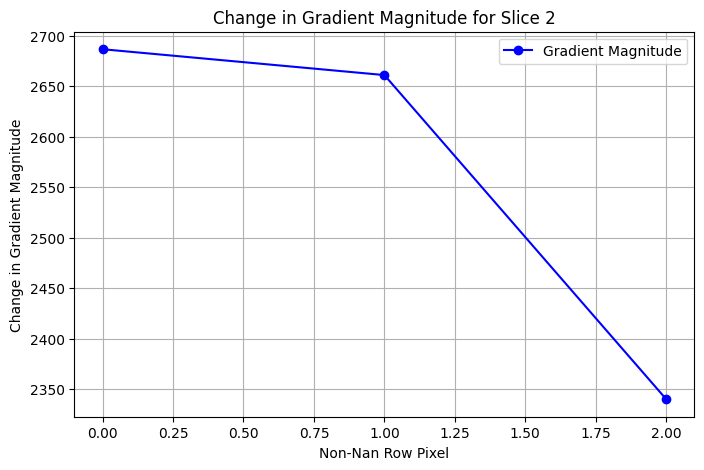

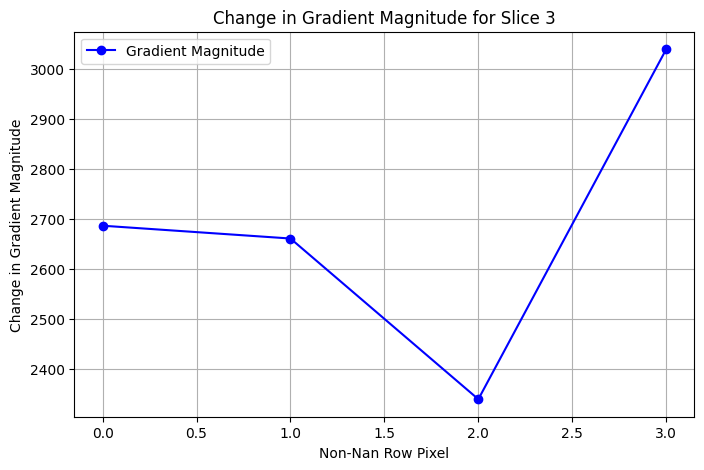

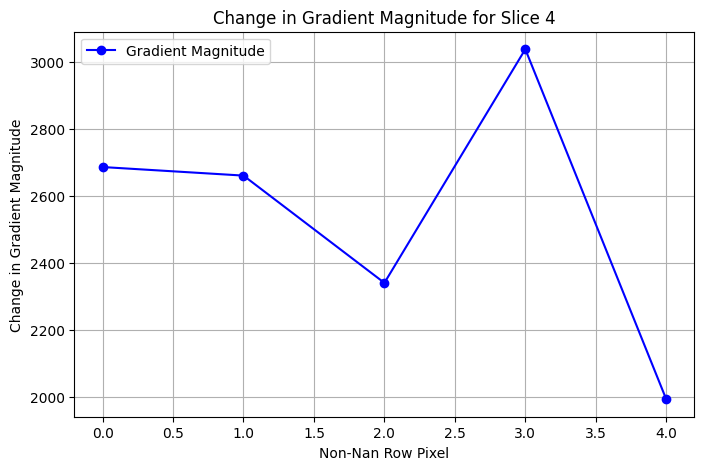

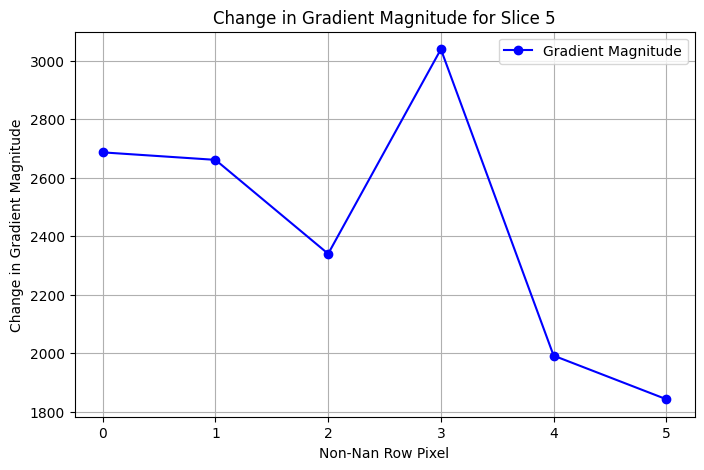

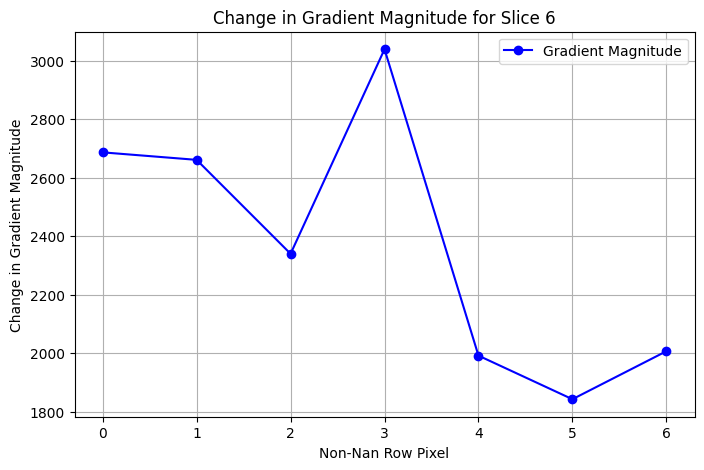

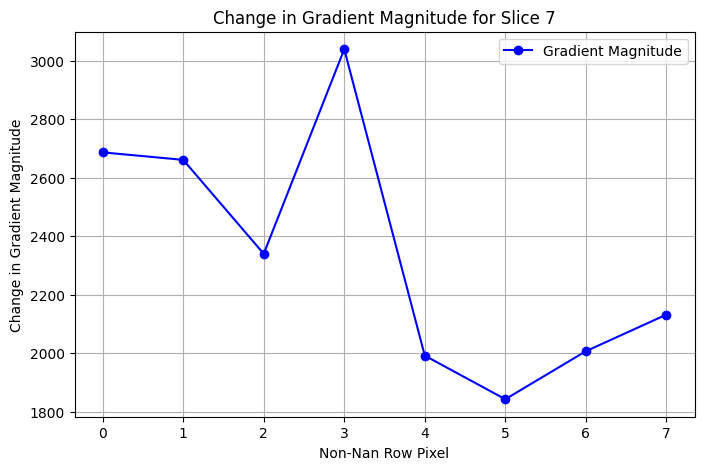

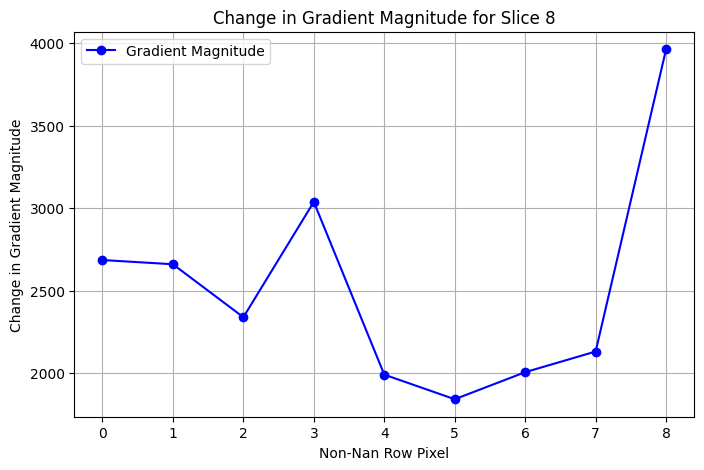

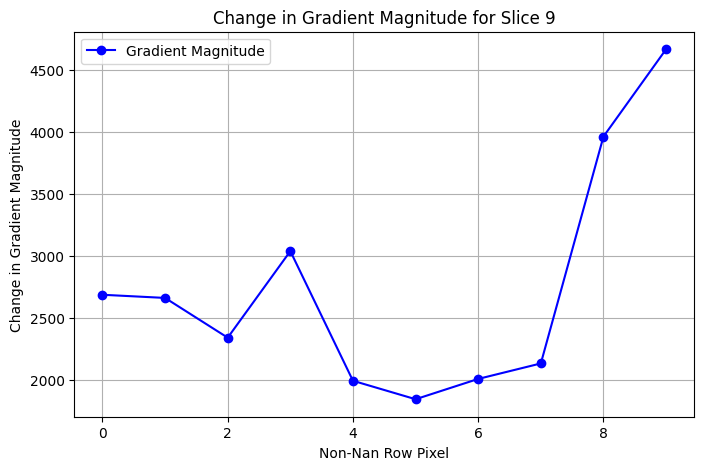

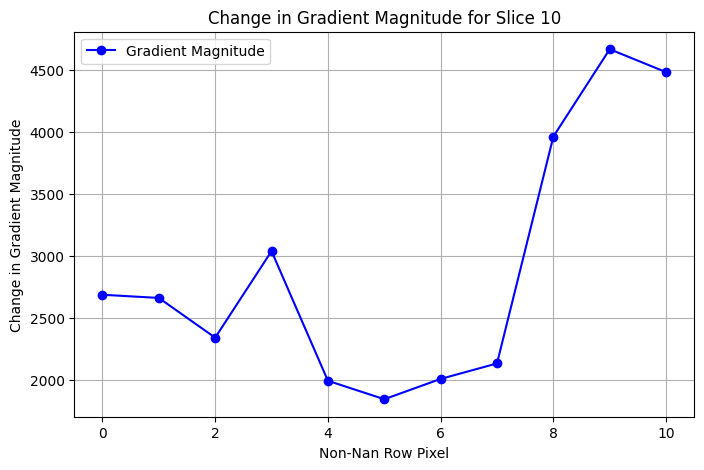

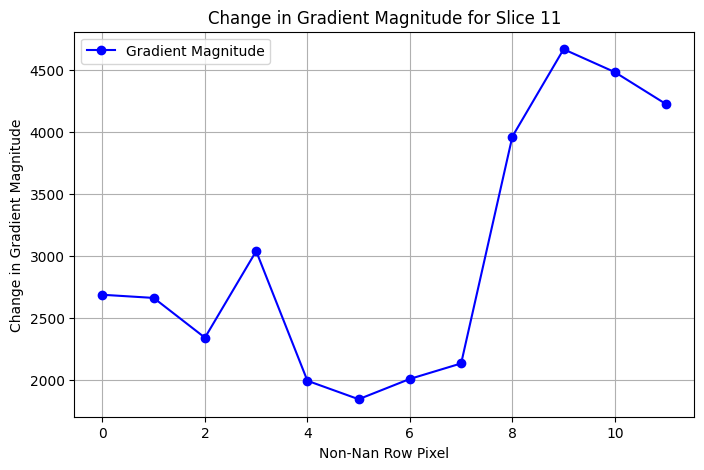

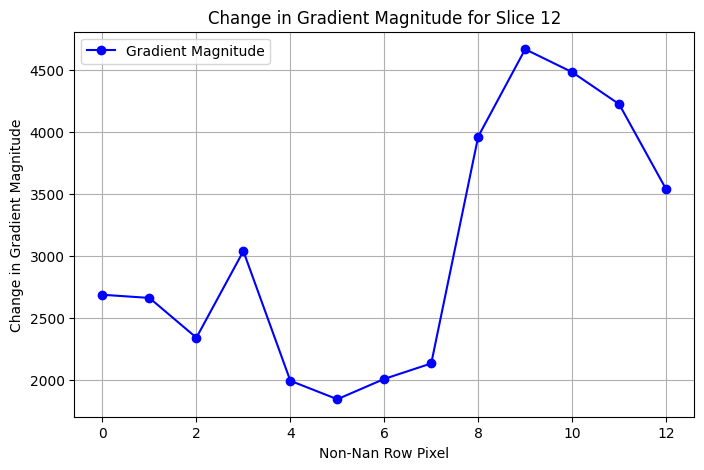

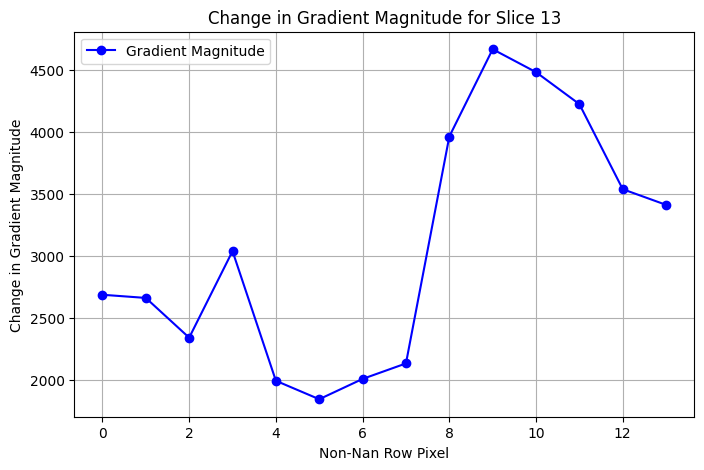

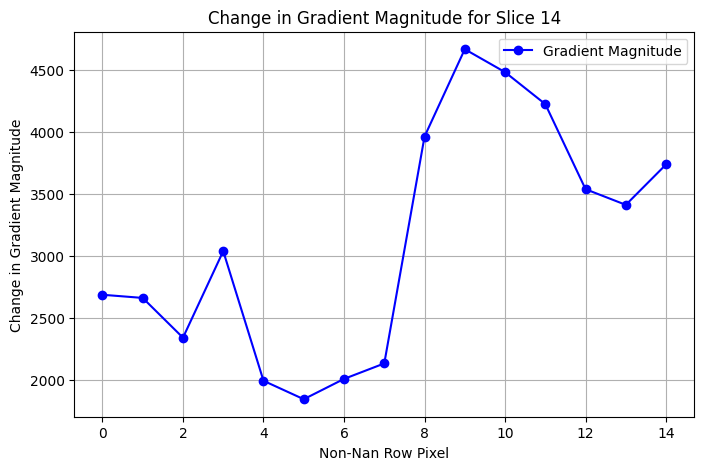

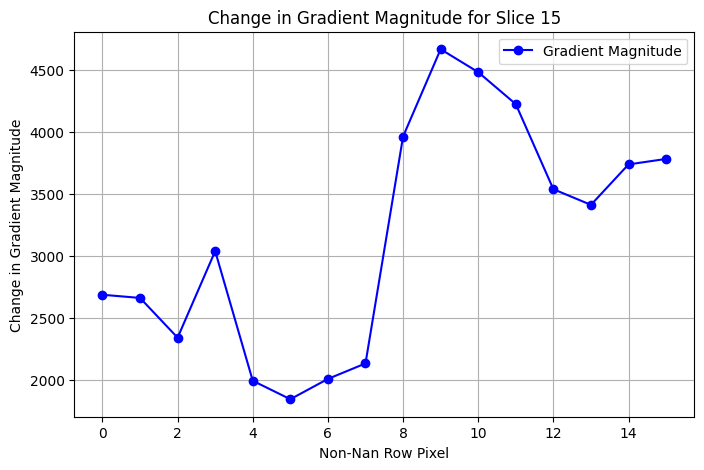

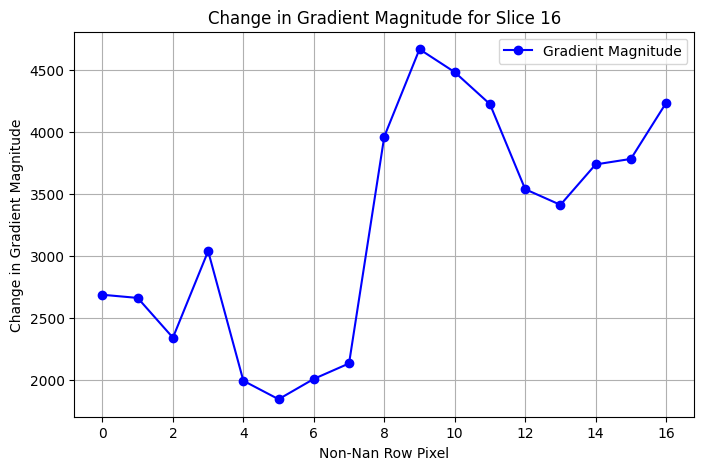

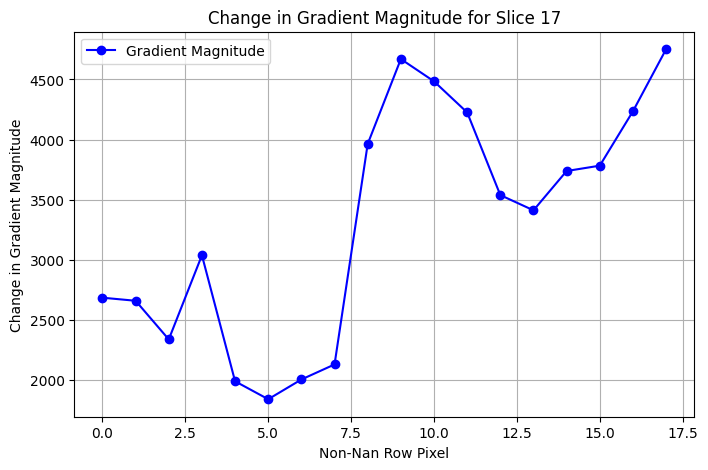

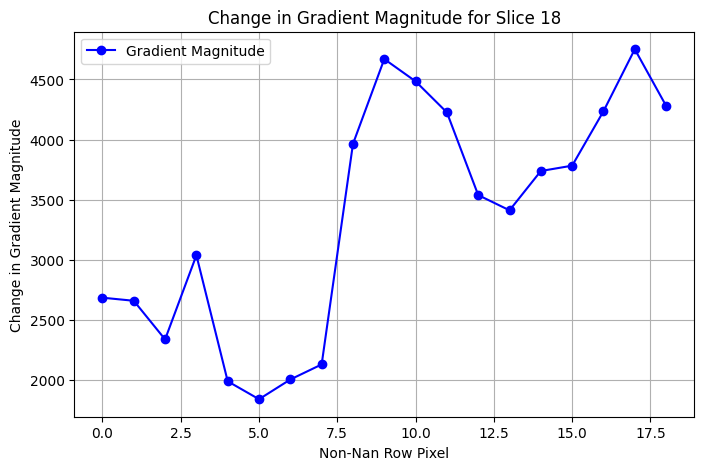

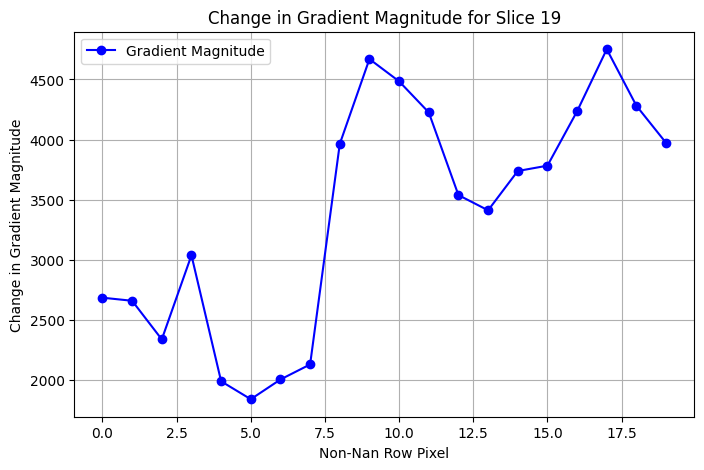

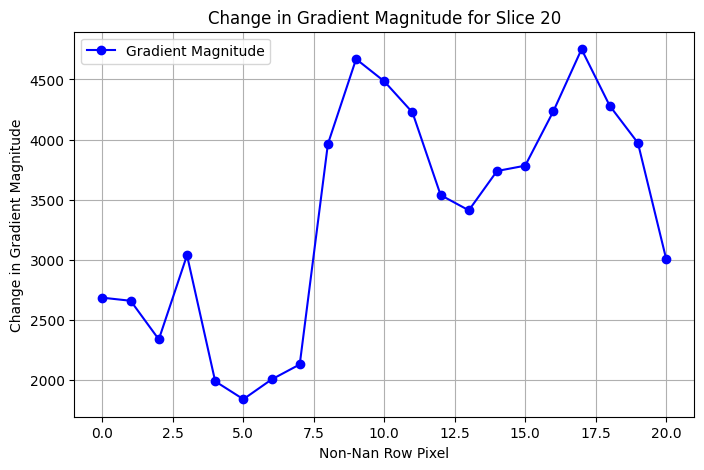

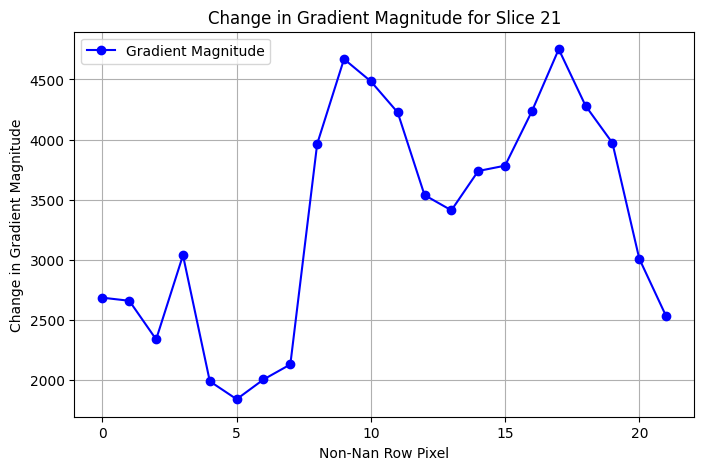

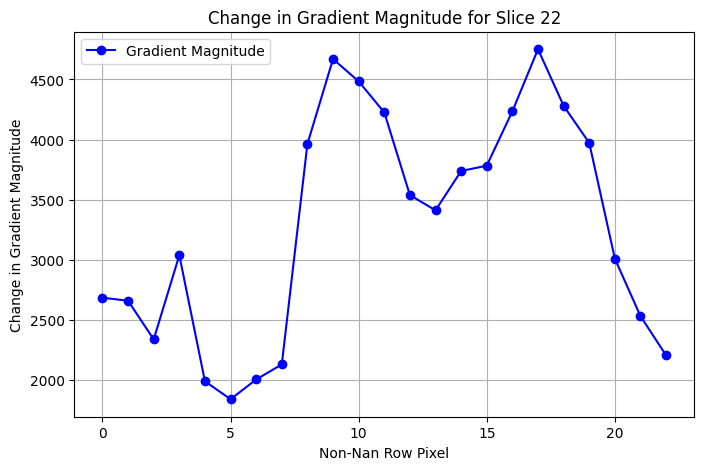

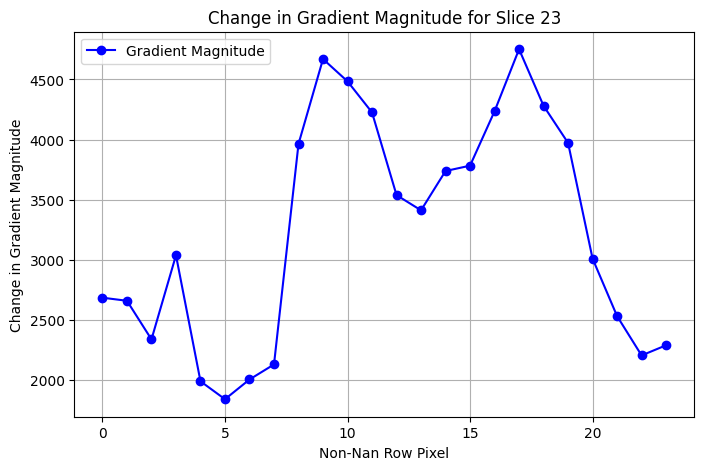

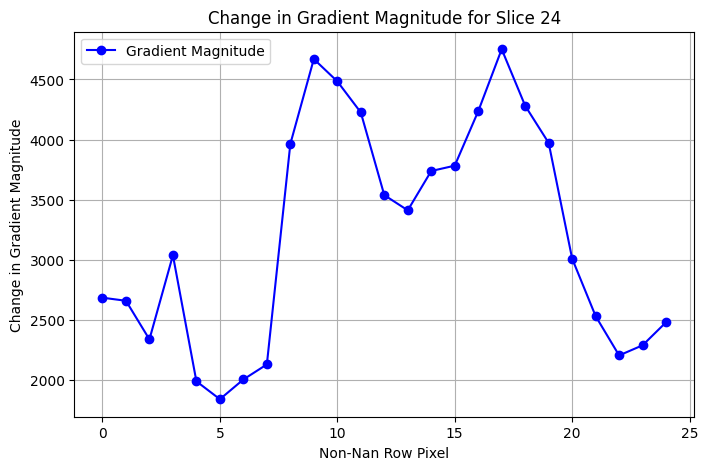

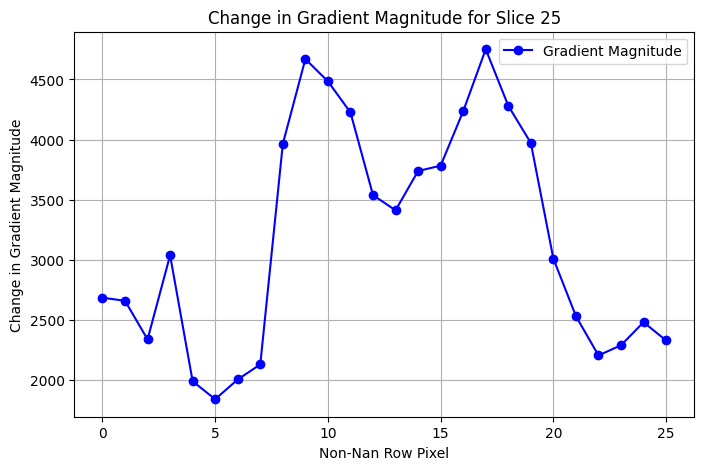

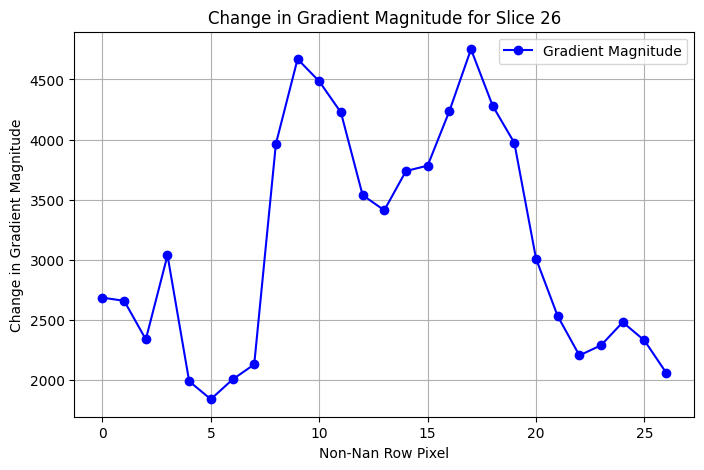

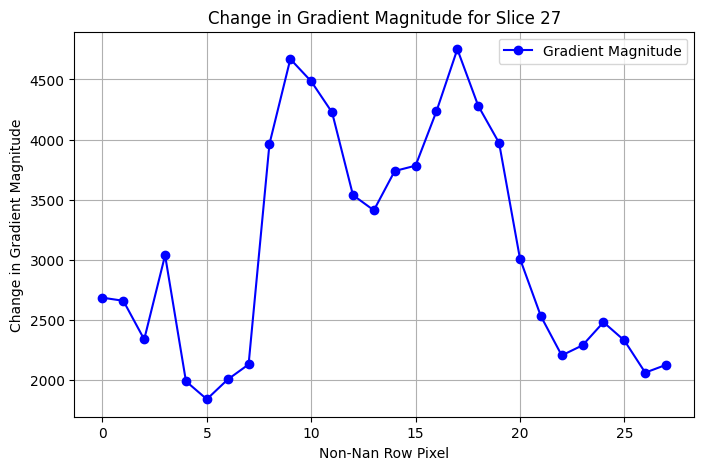

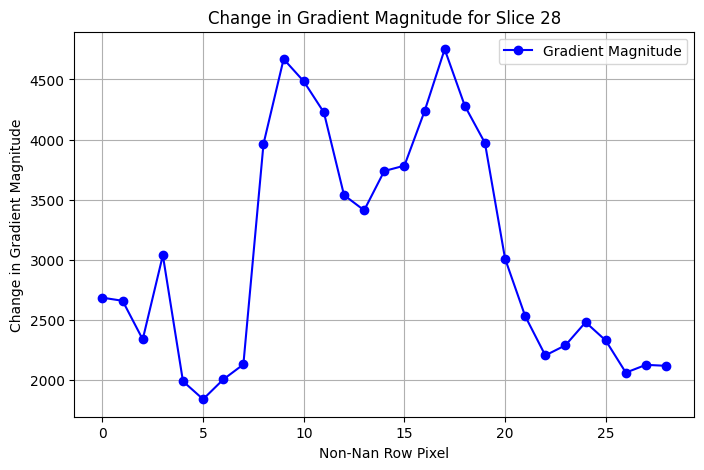

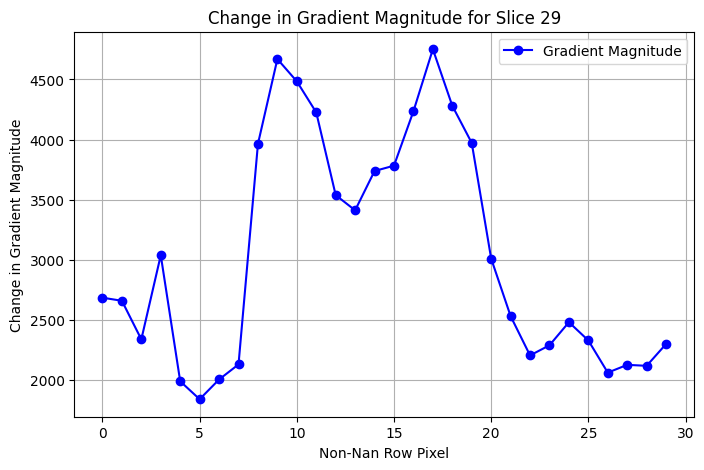

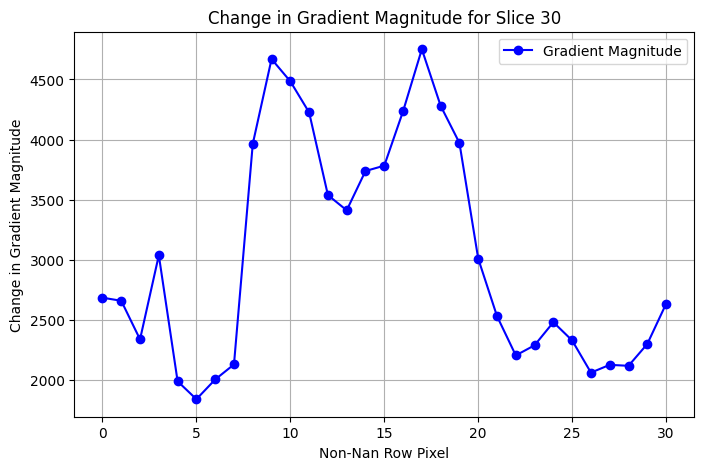

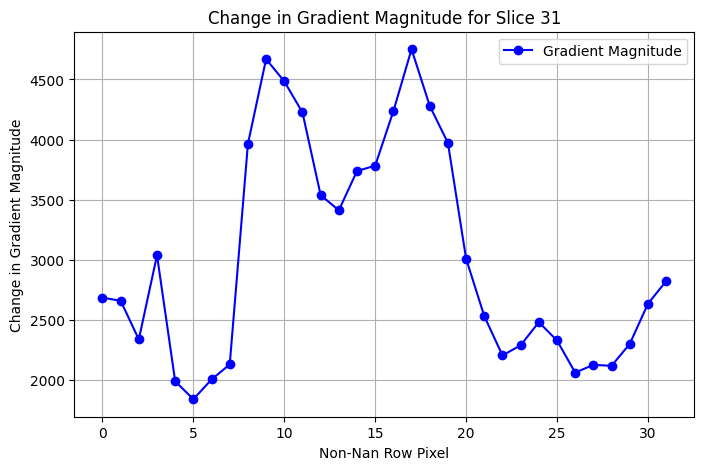

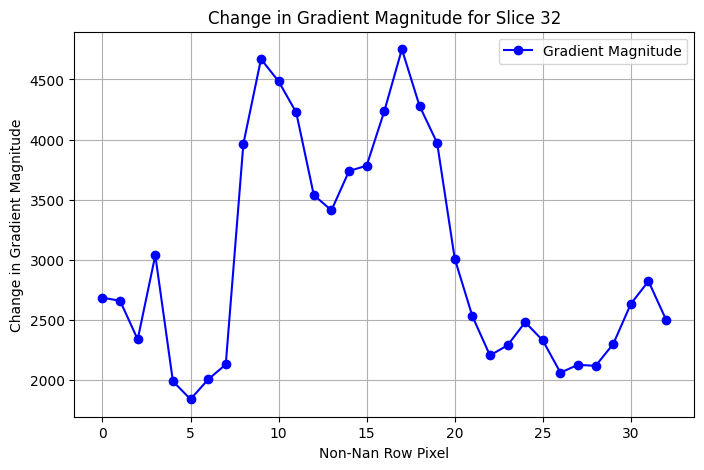

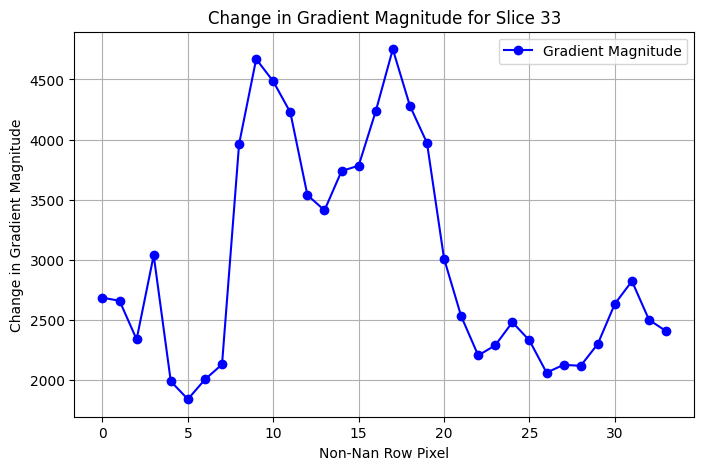

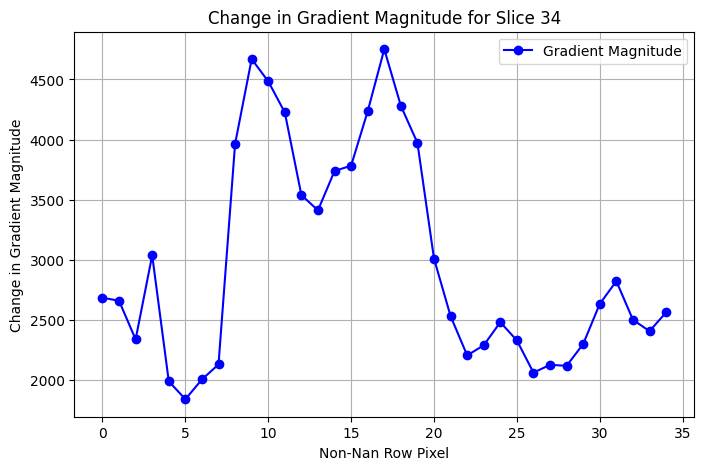

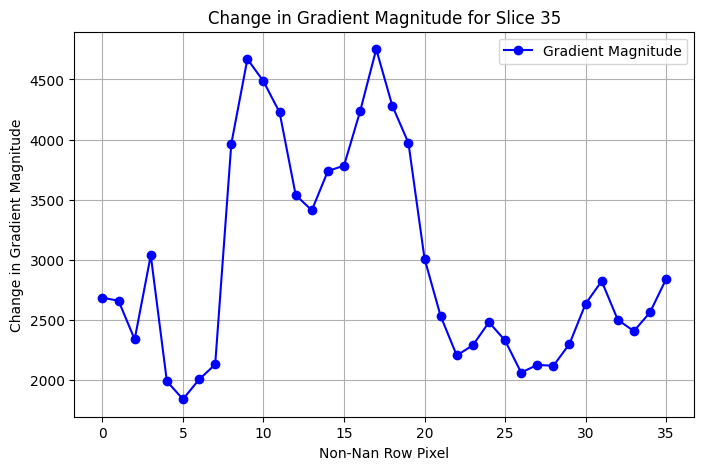

Error in callback <function flush_figures at 0x79e06b2e33a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
def monitor_grad_change(matrix, mu_path):
    subj_name = (mu_path.split("/"))[-1].split(".")[0]
    
    grad_magnitude_values = []  # Store gradient magnitude per slice
    
    for slice_x in range(matrix.shape[2]):
        selected_slice = matrix[:, :, slice_x]
        
        grad_x = scipy.ndimage.sobel(selected_slice, axis=0)
        grad_y = scipy.ndimage.sobel(selected_slice, axis=1)
        
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)  # Compute gradient magnitude
        
        # Select the central row
        col = grad_magnitude.shape[1]
        half_col = col // 2
        col_val = grad_magnitude[:, half_col]
        
        # Exclude NaN values
        col_val = col_val[~np.isnan(col_val)]
        
        # Store mean gradient magnitude for this slice
        grad_magnitude_values.append(np.mean(col_val) if col_val.size > 0 else np.nan)
        
        # print(f"Slice {slice_x}: Mean Gradient Magnitude = {grad_magnitude_values[-1]}")
        plt.figure(figsize=(8, 5))
        plt.plot(grad_magnitude_values, marker="o", linestyle="-", color="b", label="Gradient Magnitude")
        plt.xlabel("Non-Nan Row Pixel")
        plt.ylabel("Change in Gradient Magnitude")
        plt.title(f"Change in Gradient Magnitude for Slice {slice_x}")
        plt.legend()
        plt.grid(True)
        
    # print(len(grad_magnitude_values))
    return grad_magnitude_values, slice_x  # Return the values for further analysis if needed

# Run the function
monitor_grad_change(mu, mu_path)

# for value, slice_num in enumerate(grad_values, slice_num):
#     plt.figure(figsize=(8, 5))
#     plt.plot(grad_values, marker="o", linestyle="-", color="b", label="Gradient Magnitude")
#     plt.xlabel("Non-Nan Row Pixel")
#     plt.ylabel("Change in Gradient Magnitude")
#     plt.title(f"Change in Gradient Magnitude for Slice {slice_num}")
#     plt.legend()
#     plt.grid(True)

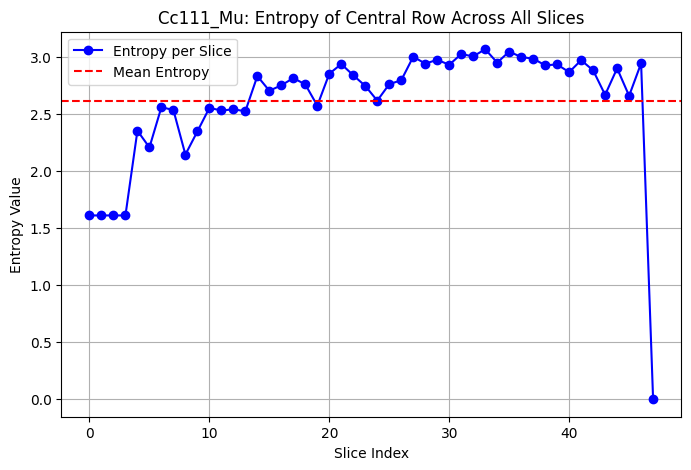

In [28]:
# for each slices, we generate matrix that records the change of magnitude

def monitor_grad_change(matrix, mu_path):
    subj_name = (mu_path.split("/"))[-1].split(".")[0]
    
    # iter thru slices
    slice_entropy_value = []
    for slice_x in range(matrix.shape[2]):
        selected_slice = matrix[:, :, slice_x]
        
        grad_x = scipy.ndimage.sobel(selected_slice, axis=0)
        grad_y = scipy.ndimage.sobel(selected_slice, axis=1)
        
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2) # grad_mag is an array
        
        # select the central row
        col = grad_magnitude.shape[1]
        half_col = col // 2
        col_val = grad_magnitude[:, half_col]
        # Exclude nan in the magnitude calculation
        col_val = col_val[~np.isnan(col_val)]
        
        # monitor the entropy of col_val 
        hist, _ = np.histogram(col_val, bins=30, density=True)
        hist = hist[hist > 0]  # Remove zero probabilities to avoid log(0) issues
        col_val_entropy = entropy(hist)
        # print(f"Slice: {slice_x} , Entropy: {col_val_entropy}")
        slice_entropy_value.append(col_val_entropy)
        
    # plot the entropy distribution for this subject
    plt.figure(figsize=(8, 5))
    plt.plot(slice_entropy_value, marker="o", linestyle="-", color="b", label="Entropy per Slice")
    plt.xlabel("Slice Index")
    plt.ylabel("Entropy Value")
    plt.title(f"{subj_name}: Entropy of Central Row Across All Slices")
    plt.axhline(y=np.mean(slice_entropy_value), color="r", linestyle="dashed", label="Mean Entropy")
    plt.legend()
    plt.grid(True)
    
monitor_grad_change(mu, mu_path)



### 3. Generate a probability map for all the data 

Grace's Matlab Code

%% Creating Probability Map
Mu_prob = zeros(size(Mu));
for xx = 1:size(Mu,1)
    for yy = 1:size(Mu,2)
        for zz = 1:size(Mu,3)
            if Mu(xx,yy,zz)>10000
                Mu_prob(xx,yy,zz)=.99;
            elseif Mu(xx,yy,zz)>8000 & Mu(xx,yy,zz)<10000
                Mu_prob(xx,yy,zz)=.80;
           elseif Mu(xx,yy,zz)>6000 & Mu(xx,yy,zz)<8000
                Mu_prob(xx,yy,zz)=.60;
          elseif Mu(xx,yy,zz)>5000 & Mu(xx,yy,zz)<6000
                Mu_prob(xx,yy,zz)=.50;
            elseif Mu(xx,yy,zz)<5000
                 Mu_prob(xx,yy,zz)=0;
        end
    end
end
end


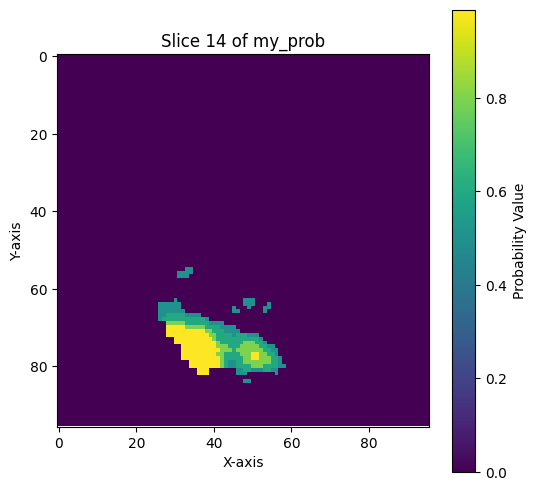

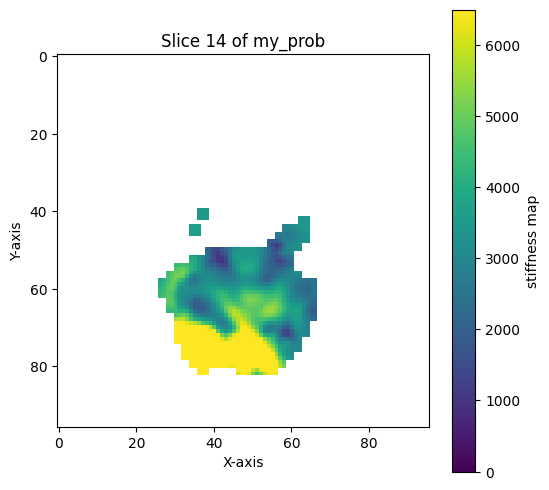

In [ ]:
def generate_prob_map(matrix):
    """
    This function will generate the probability map based on the some threshold manually defined. 
    
    The stiffness threshold can be tuned in the future. 
    
    Params:
        - matrix: the 3D stiffness matrix. 
    """
    # initialize an empty matrix with the same size as matrix 
    Mu_prob = np.zeros(matrix.shape)
    
    # iter through each element in the 3D stiffness matrix
    x_range = matrix.shape[0]
    y_range = matrix.shape[1]
    z_range = matrix.shape[2]
    
    for xx in range(x_range):
        for yy in range(y_range):
            for zz in range(z_range):
                value = (xx, yy, zz)
                
                if matrix[value] > 10000:
                    Mu_prob[value] = 0.99 # 99% probability that this should be filtered out 
                    
                elif matrix[value] > 8000 and matrix[value] <10000:
                    Mu_prob[value] = 0.80
                
                elif matrix[value] > 6000 and matrix[value] < 8000:
                        Mu_prob[value] = 0.60
                        
                elif matrix[value] > 5000 and matrix[value] < 6000:
                        Mu_prob[value] = 0.50
                        
                elif matrix[value] < 5000: 
                        Mu_prob[value] = 0
    return Mu_prob
    # print(Mu_prob)

my_porb = generate_prob_map(mu)

# plot and visualize this
interested = my_porb[:, :, 16]

plt.figure(figsize=(6, 6))
plt.imshow(interested, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Probability Value")
plt.title("Slice 14 of prob")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

orig = mu[:, :, 14]
plt.figure(figsize=(6, 6))
plt.imshow(orig, cmap='viridis', interpolation='nearest', vmin=0, vmax=6500)
plt.colorbar(label="stiffness map")
plt.title("Stiffness Map")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

